In [ ]:
pip install optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna

# Assuming the data is loaded into a DataFrame
#df = pd.read_csv("/content/drive/MyDrive/DS_project/cleaned_Helsinki_dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/DS_project/Train_Helsinki_obs_data.csv")

# Extract hour as an integer from the time string
df['Hour'] = df['Time [Local time]'].str.split(':').str[0].astype(int)

df.columns

<ipython-input-23-f20ddc46ea1a>:10: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['Location', 'Year', 'Month', 'Day', 'Time [Local time]',
       'Average temperature [°C]', 'Average relative humidity [%]',
       'Wind speed [m/s]', 'Average wind direction [°]', 'Precipitation [mm]',
       'Average air pressure [hPa]', 'Fine particles <2.5 µm [µg/m3]',
       'Datetime', 'Hour'],
      dtype='object')

In [ ]:
df.tail(5)

,Location,Year,Month,Day,Time [Local time],Average temperature [°C],Average relative humidity [%],Wind speed [m/s],Average wind direction [°],Precipitation [mm],Average air pressure [hPa],Fine particles <2.5 µm [µg/m3],Datetime,Hour
134088,Helsinki,2025,4,17,19:00,10.3,86.0,3.5,109,0.0,1016.4,5.0,2025-04-14 1:00:00,19
134089,Helsinki,2025,4,17,20:00,9.6,89.0,3.3,116,0.0,1016.6,4.9,2025-04-14 2:00:00,20
134090,Helsinki,2025,4,17,21:00,7.7,95.0,2.3,134,0.0,1016.9,6.5,2025-04-13 21:00:00,21
134091,Helsinki,2025,4,17,22:00,7.1,97.0,2,126,0.0,1016.9,4.5,2025-04-13 22:00:00,22
134092,Helsinki,2025,4,17,23:00,7.1,98.0,1.9,115,0.0,1016.9,5.9,2025-04-13 23:00:00,23


In [ ]:

# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-' +
    df['Day'].astype(str).str.zfill(2) + ' ' +
    df['Time [Local time]'].astype(str),
    format='%Y-%m-%d %H:%M'
)

df['Datetime'] = pd.to_datetime(df['Datetime'])
# Extract day of the week from the 'Datetime' column (0=Monday, 6=Sunday)
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df['Datetime'].max()

Timestamp('2025-04-17 23:00:00')

<ipython-input-27-32f39dfec310>:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




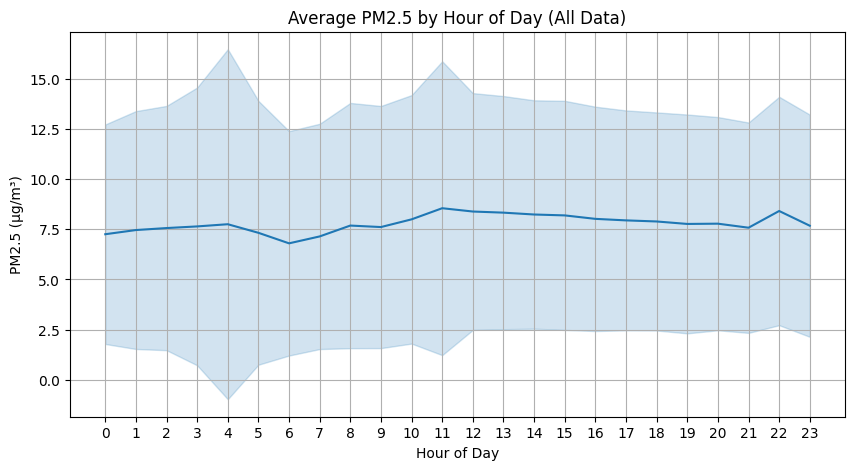

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot average PM2.5 by hour of day
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Hour', y='Fine particles <2.5 µm [µg/m3]', estimator='mean', ci='sd')
plt.title('Average PM2.5 by Hour of Day (All Data)')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


In [ ]:
# winter 1,Spring 2,
def map_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(map_season)


<ipython-input-29-f4ca950960e6>:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.




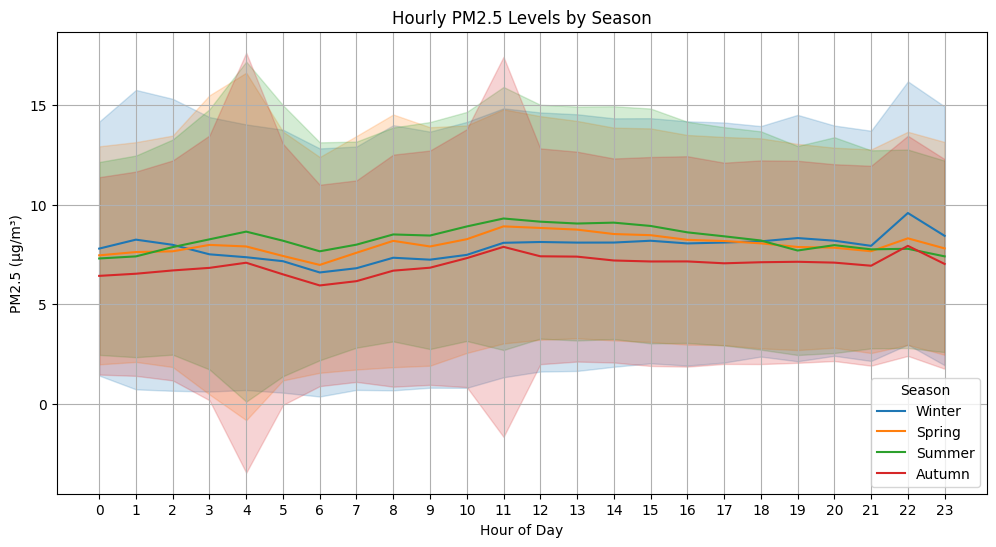

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Hour', y='Fine particles <2.5 µm [µg/m3]', hue='Season', estimator='mean', ci='sd')
plt.title('Hourly PM2.5 Levels by Season')
plt.xlabel('Hour of Day')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend(title='Season')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


# Get Test Set from simulation data

In [ ]:
import pandas as pd

test_df = pd.read_csv("/content/drive/MyDrive/DS_project/test_sim.csv")
test_df['Hour'] = test_df['Time'].str.split(':').str[0].astype(int)
test_df['Year'] = 2025
# Combine columns into a datetime string and parse it
test_df['Datetime'] = pd.to_datetime(
    test_df['Year'].astype(str) + '-' +
    test_df['Month'].astype(str).str.zfill(2) + '-' +
    test_df['Day'].astype(str).str.zfill(2) + ' ' +
    test_df['Time'].astype(str),
    format='%Y-%m-%d %H:%M'
)
# Convert 'Datetime' column to datetime format
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'])
# Extract day of the week from the 'Datetime' column (0=Monday, 6=Sunday)
test_df['dayofweek'] = test_df['Datetime'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
test_df['Average wind direction [°]']= test_df['Wind direction [°]']
test_df['Datetime'].max()

test_df['Season'] = test_df['Month'].apply(map_season)
test_df.head(5)

,Year,Month,Day,Time,Average temperature [°C],Average relative humidity [%],Average air pressure [hPa],Precipitation [mm],Wind speed [m/s],Wind direction [°],...,winw,winz,snow,Fine particles <2.5 µm [µg/m3],Hour,Datetime,dayofweek,weekend,Average wind direction [°],Season
0,2025,4,9,0:00,0.26843,78.272920,1009.68984,0.0,0.524810,274.845669,...,-0.000154,0.522934,0.0,6.789915,0,2025-04-09 00:00:00,2,0,274.845669,Spring
1,2025,4,9,1:00,-0.01224,78.682655,1008.90300,0.0,0.624581,277.362545,...,-0.000307,0.619431,0.0,6.854713,1,2025-04-09 01:00:00,2,0,277.362545,Spring
2,2025,4,9,2:00,0.03765,79.375434,1007.65630,0.0,0.673314,276.672465,...,-0.000206,0.668753,0.0,6.903421,2,2025-04-09 02:00:00,2,0,276.672465,Spring
3,2025,4,9,3:00,0.42648,79.983180,1006.52840,0.0,0.741183,282.494540,...,-0.000064,0.723629,0.0,6.511087,3,2025-04-09 03:00:00,2,0,282.494540,Spring
4,2025,4,9,4:00,1.45965,79.676324,1005.17610,0.0,0.683553,302.705613,...,-0.002171,0.575181,0.0,5.408816,4,2025-04-09 04:00:00,2,0,302.705613,Spring


In [ ]:
test_df.columns

Index(['Year', 'Month', 'Day', 'Time', 'Average temperature [°C]',
       'Average relative humidity [%]', 'Average air pressure [hPa]',
       'Precipitation [mm]', 'Wind speed [m/s]', 'Wind direction [°]', 'winm',
       'winw', 'winz', 'snow', 'Fine particles <2.5 µm [µg/m3]', 'Hour',
       'Datetime', 'dayofweek', 'weekend', 'Average wind direction [°]',
       'Season'],
      dtype='object')

In [ ]:

columns_to_keep = [
    'Year', 'Month', 'Day',
    'Average temperature [°C]',
    'Average relative humidity [%]',
    'Wind speed [m/s]',
    'Average wind direction [°]',
    'Precipitation [mm]',
    'Average air pressure [hPa]',
    'Fine particles <2.5 µm [µg/m3]',
    'Datetime','Hour','dayofweek','weekend','Season']

test_df = test_df[columns_to_keep]

In [ ]:
print(df.dtypes)
df = df.sort_values(by='Datetime')  # Ensure data is sorted by datetime

Location                                  object
Year                                       int64
Month                                      int64
Day                                        int64
Time [Local time]                         object
Average temperature [°C]                 float64
Average relative humidity [%]            float64
Wind speed [m/s]                          object
Average wind direction [°]                object
Precipitation [mm]                       float64
Average air pressure [hPa]               float64
Fine particles <2.5 µm [µg/m3]           float64
Datetime                          datetime64[ns]
Hour                                       int64
dayofweek                                  int32
weekend                                    int64
Season                                    object
dtype: object


In [ ]:
# Specify columns to replace '-'
columns_to_replace = ['Wind speed [m/s]', 'Average wind direction [°]']

# Shift the relevant columns to get the previous hour's values
for column in columns_to_replace:
    df[column] = df[column].where(df[column] != '-', df[column].shift(1))
    test_df[column] = test_df[column].where(test_df[column] != '-', test_df[column].shift(1))

df = df.round(2)
test_df = test_df.round(2)
# Show the updated dataframe
print(df['Wind speed [m/s]'].unique())
print(df['Average wind direction [°]'].unique())


[4.2 4.9 3.8 4.7 5.1 4.8 4.5 5.2 4.4 3.5 4.1 4.6 5.6 5.3 4.0 3.9 3.7 3.0
 3.4 3.2 2.9 2.8 2.5 2.4 2.7 2.0 3.702840636 2.1 1.8 1.9 0.7 0.6 2.3 4.3
 3.3 2.6 1.7 1.6 1.1 1.0 1.5 1.4 0.9 1.2 1.3 2.2 3.6 5.5 5.0 5.7 5.9 0.8
 3.1 6.1 6.8 7.1 8.4 5.4 6.4 7.4 7.8 7.7 7.3 7.0 5.8 6.0 6.5 6.7 6.6 6.3
 6.9 6.2 8.8 8.2 7.6 0.4 7.2 0.5 8.0 8.1 8.9 7.5 8.5 9.0 9.4 8.7 9.1 8.6
 10.7 9.9 9.2 7.9 8.3 9.3 11.8 11.4 11.3 10.3 9.6 9.5 9.8 9.7 10.8 11.5
 11.0 11.2 10.2 10.0 10.6 11.9 11.1 10.5 10.1 12.9 13.3 14.3 13.9 12.4
 11.7 10.9 0.3 10.4 12.1 12.8 12.0 12.3 11.6 0.2 12.6 12.7 13.7 14.7 '5'
 '4.4' '4.1' '3.6' '3.2' '3.5' '2.5' '2.3' '2.7' '2.9' '2.4' '2.8' '3.9'
 '4.6' '5.2' '4.5' '4.3' '4' '3.4' '2' '1.4' '1' '1.3' '1.1' '2.1' '2.6'
 '5.5' '6' '5.4' '3.3' '3.1' '3.7' '6.1' '6.7' '6.8' '6.3' '5.9' '4.9'
 '4.2' '1.7' '1.2' '5.8' '7.9' '8.3' '8.5' '6.4' '7.3' '7.6' '8.2' '8' '7'
 '5.7' '6.9' '7.2' '7.4' '6.5' '5.6' '3.8' '7.1' '1.9' '2.2' '1.8' '6.6'
 '7.8' '7.5' '8.8' '7.7' '5.1' '3' '8.9' '8.4' '4.8' '

In [ ]:
import pandas as pd

# df is your DataFrame
filtered_df = df[df.isin(['-']).any(axis=1)]
filtered_df

,Location,Year,Month,Day,Time [Local time],Average temperature [°C],Average relative humidity [%],Wind speed [m/s],Average wind direction [°],Precipitation [mm],Average air pressure [hPa],Fine particles <2.5 µm [µg/m3],Datetime,Hour,dayofweek,weekend,Season


In [ ]:
# Specify columns that should be numeric
numeric_columns = [
    'Average temperature [°C]',
    'Average relative humidity [%]',
    'Wind speed [m/s]',
    'Average wind direction [°]',
    'Precipitation [mm]',
    'Average air pressure [hPa]',
    'Fine particles <2.5 µm [µg/m3]'
]

# Replace unwanted characters ('-' or any other non-numeric) with NaN and convert to numeric
for column in numeric_columns:
    # Replace '-' with NaN and convert the column to numeric
    df[column] = pd.to_numeric(df[column].replace({'-': np.nan}), errors='coerce')
    test_df[column] = pd.to_numeric(test_df[column].replace({'-': np.nan}), errors='coerce')

# Display the dataframe to check the conversion
print(df)
df.dtypes

        Location  Year  Month  Day Time [Local time]  \
0       Helsinki  2010      1    1              0:00   
1       Helsinki  2010      1    1              1:00   
2       Helsinki  2010      1    1              2:00   
3       Helsinki  2010      1    1              3:00   
4       Helsinki  2010      1    1              4:00   
...          ...   ...    ...  ...               ...   
134088  Helsinki  2025      4   17             19:00   
134089  Helsinki  2025      4   17             20:00   
134090  Helsinki  2025      4   17             21:00   
134091  Helsinki  2025      4   17             22:00   
134092  Helsinki  2025      4   17             23:00   

        Average temperature [°C]  Average relative humidity [%]  \
0                          -10.5                           89.0   
1                          -10.6                           89.0   
2                          -10.3                           89.0   
3                          -10.2                           

,0
Location,object
Year,int64
Month,int64
Day,int64
Time [Local time],object
Average temperature [°C],float64
Average relative humidity [%],float64
Wind speed [m/s],float64
Average wind direction [°],float64
Precipitation [mm],float64


In [ ]:
print(df[df['Average temperature [°C]'].isna()])

Empty DataFrame
Columns: [Location, Year, Month, Day, Time [Local time], Average temperature [°C], Average relative humidity [%], Wind speed [m/s], Average wind direction [°], Precipitation [mm], Average air pressure [hPa], Fine particles <2.5 µm [µg/m3], Datetime, Hour, dayofweek, weekend, Season]
Index: []


In [ ]:
print(df[df.isna().all(axis=1)])

Empty DataFrame
Columns: [Location, Year, Month, Day, Time [Local time], Average temperature [°C], Average relative humidity [%], Wind speed [m/s], Average wind direction [°], Precipitation [mm], Average air pressure [hPa], Fine particles <2.5 µm [µg/m3], Datetime, Hour, dayofweek, weekend, Season]
Index: []


In [ ]:
print(df.isna().sum())

Location                          0
Year                              0
Month                             0
Day                               0
Time [Local time]                 0
Average temperature [°C]          0
Average relative humidity [%]     0
Wind speed [m/s]                  0
Average wind direction [°]        0
Precipitation [mm]                0
Average air pressure [hPa]        0
Fine particles <2.5 µm [µg/m3]    0
Datetime                          0
Hour                              0
dayofweek                         0
weekend                           0
Season                            0
dtype: int64


In [ ]:
print(test_df.isna().sum())

Year                              0
Month                             0
Day                               0
Average temperature [°C]          0
Average relative humidity [%]     0
Wind speed [m/s]                  0
Average wind direction [°]        0
Precipitation [mm]                0
Average air pressure [hPa]        0
Fine particles <2.5 µm [µg/m3]    0
Datetime                          0
Hour                              0
dayofweek                         0
weekend                           0
Season                            0
dtype: int64


In [ ]:
import re
# Create lag features for the target variable 'Fine particles <2.5 µm [µg/m3]'
for i in range(24, 26):  # Create lags for 24 hours
    df[f'Fine_particles_lag_{i}'] = df['Fine particles <2.5 µm [µg/m3]'].shift(i)
    test_df[f'Fine_particles_lag_{i}'] = test_df['Fine particles <2.5 µm [µg/m3]'].shift(i)

# Create lag features for other variables like temperature, wind speed, etc.
variables_to_lag = [
    'Average temperature [°C]',
    'Average relative humidity [%]',
    'Wind speed [m/s]',
    'Average wind direction [°]',
    'Precipitation [mm]',
    'Average air pressure [hPa]']
for i in range(24, 26):
    for var in variables_to_lag:
        clean_var = re.sub(r'[^A-Za-z0-9_]', '_', var)
        col_name = f"{clean_var}_lag_{i}"
        df[col_name] = df[var].shift(i)
        test_df[col_name] = test_df[var].shift(i)

# Drop rows with missing values caused by lagging
df = df.dropna()
df = df[df['Fine particles <2.5 µm [µg/m3]'] >= 0]

# Define features and target
features = ['Month', 'Hour','dayofweek','weekend','Fine_particles_lag_24',
       'Fine_particles_lag_25', 'Average_temperature___C__lag_24',
       'Average_relative_humidity_____lag_24', 'Wind_speed__m_s__lag_24',
       'Average_wind_direction_____lag_24', 'Precipitation__mm__lag_24',
       'Average_air_pressure__hPa__lag_24',
       'Average_temperature___C__lag_25',
       'Average_relative_humidity_____lag_25', 'Wind_speed__m_s__lag_25',
       'Average_wind_direction_____lag_25', 'Precipitation__mm__lag_25',
       'Average_air_pressure__hPa__lag_25']
#features += ['Month', 'Hour','dayofweek','weekend']
############################
#target = 'Fine particles <2.5 µm [µg/m3]'
# Transform before training
df['log_pm25'] = np.log1p(df['Fine particles <2.5 µm [µg/m3]'])

# After prediction, reverse it: IMPORTANT BELOW
####   y_pred_original = np.expm1(model.predict(X_test))
# Then train your model with 'log_pm25' as the target

target = 'log_pm25'
train_df = df.copy()
###########################################################################
train_df.head(5)

,Location,Year,Month,Day,Time [Local time],Average temperature [°C],Average relative humidity [%],Wind speed [m/s],Average wind direction [°],Precipitation [mm],...,Average_wind_direction_____lag_24,Precipitation__mm__lag_24,Average_air_pressure__hPa__lag_24,Average_temperature___C__lag_25,Average_relative_humidity_____lag_25,Wind_speed__m_s__lag_25,Average_wind_direction_____lag_25,Precipitation__mm__lag_25,Average_air_pressure__hPa__lag_25,log_pm25
25,Helsinki,2010,1,2,1:00,-18.4,83.0,3.8,19.0,0.1,...,46.0,0.1,1002.3,-10.5,89.0,4.2,47.0,0.1,1001.9,2.164472
26,Helsinki,2010,1,2,2:00,-18.7,82.0,3.5,19.0,0.1,...,44.0,0.1,1002.5,-10.6,89.0,4.9,46.0,0.1,1002.3,2.164472
27,Helsinki,2010,1,2,3:00,-19.0,82.0,4.0,17.0,0.1,...,43.0,0.1,1002.9,-10.3,89.0,3.8,44.0,0.1,1002.5,2.104134
28,Helsinki,2010,1,2,4:00,-19.0,82.0,4.4,18.0,0.1,...,45.0,0.1,1003.2,-10.2,89.0,4.7,43.0,0.1,1002.9,2.370244
29,Helsinki,2010,1,2,5:00,-18.0,82.0,4.6,20.0,0.1,...,44.0,0.1,1003.5,-10.2,89.0,5.1,45.0,0.1,1003.2,2.451005


In [ ]:
# Check for missing values in test_df
print("\nNull values in test_df by column:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])

print("\nRows in test_df with missing values:")
print(test_df[test_df.isnull().any(axis=1)])


Null values in test_df by column:
Fine_particles_lag_24                   24
Fine_particles_lag_25                   25
Average_temperature___C__lag_24         24
Average_relative_humidity_____lag_24    24
Wind_speed__m_s__lag_24                 24
Average_wind_direction_____lag_24       24
Precipitation__mm__lag_24               24
Average_air_pressure__hPa__lag_24       24
Average_temperature___C__lag_25         25
Average_relative_humidity_____lag_25    25
Wind_speed__m_s__lag_25                 25
Average_wind_direction_____lag_25       25
Precipitation__mm__lag_25               25
Average_air_pressure__hPa__lag_25       25
dtype: int64

Rows in test_df with missing values:
    Year  Month  Day  Average temperature [°C]  Average relative humidity [%]  \
0   2025      4    9                      0.27                          78.27   
1   2025      4    9                     -0.01                          78.68   
2   2025      4    9                      0.04                       

In [ ]:
test_df.columns

Index(['Year', 'Month', 'Day', 'Average temperature [°C]',
       'Average relative humidity [%]', 'Wind speed [m/s]',
       'Average wind direction [°]', 'Precipitation [mm]',
       'Average air pressure [hPa]', 'Fine particles <2.5 µm [µg/m3]',
       'Datetime', 'Hour', 'dayofweek', 'weekend', 'Season',
       'Fine_particles_lag_24', 'Fine_particles_lag_25',
       'Average_temperature___C__lag_24',
       'Average_relative_humidity_____lag_24', 'Wind_speed__m_s__lag_24',
       'Average_wind_direction_____lag_24', 'Precipitation__mm__lag_24',
       'Average_air_pressure__hPa__lag_24', 'Average_temperature___C__lag_25',
       'Average_relative_humidity_____lag_25', 'Wind_speed__m_s__lag_25',
       'Average_wind_direction_____lag_25', 'Precipitation__mm__lag_25',
       'Average_air_pressure__hPa__lag_25'],
      dtype='object')

In [ ]:
test_df.tail(5)

,Year,Month,Day,Average temperature [°C],Average relative humidity [%],Wind speed [m/s],Average wind direction [°],Precipitation [mm],Average air pressure [hPa],Fine particles <2.5 µm [µg/m3],...,Wind_speed__m_s__lag_24,Average_wind_direction_____lag_24,Precipitation__mm__lag_24,Average_air_pressure__hPa__lag_24,Average_temperature___C__lag_25,Average_relative_humidity_____lag_25,Wind_speed__m_s__lag_25,Average_wind_direction_____lag_25,Precipitation__mm__lag_25,Average_air_pressure__hPa__lag_25
139,2025,4,14,4.35,78.28,0.63,160.03,0.0,1009.01,5.82,...,0.63,160.03,0.0,1009.01,4.38,78.98,0.55,168.03,0.0,1009.51
140,2025,4,14,3.94,79.76,0.59,159.17,0.0,1008.53,5.90,...,0.59,159.17,0.0,1008.53,4.35,78.28,0.63,160.03,0.0,1009.01
141,2025,4,14,3.28,83.06,0.51,156.87,0.0,1008.09,6.04,...,0.51,156.87,0.0,1008.09,3.94,79.76,0.59,159.17,0.0,1008.53
142,2025,4,14,2.73,86.76,0.37,143.24,0.0,1007.62,6.18,...,0.37,143.24,0.0,1007.62,3.28,83.06,0.51,156.87,0.0,1008.09
143,2025,4,14,2.56,88.67,0.27,140.11,0.0,1007.12,6.32,...,0.27,140.11,0.0,1007.12,2.73,86.76,0.37,143.24,0.0,1007.62


In [ ]:
train_test_obs_list = []
train_test_sim_list = []

for current_date in pd.date_range(start='2025-04-11', end='2025-04-14'):

    train_cutoff = current_date - pd.Timedelta(days=1)

    # Train data up to the day before the current date
    train_data = train_df[(train_df['Datetime'] < current_date)].copy()

    # Test data for the current date
    start_time = pd.Timestamp(current_date.date())
    end_time = start_time + pd.Timedelta(days=1)
    print(f"Processing date: {current_date.date()}")
    print(f"Start time: {start_time}")
    print(f"End time: {end_time}")

    print("Train DF Range:", train_df['Datetime'].min(), "to", train_df['Datetime'].max())
    print("Test DF Range:", test_df['Datetime'].min(), "to", test_df['Datetime'].max())

    print("\nSample from train_df:")
    print(train_df['Datetime'].head(3))
    print(train_df['Datetime'].tail(3))

    print("\nSample from test_df:")
    print(test_df['Datetime'].head(3))
    print(test_df['Datetime'].tail(3))

    # Now use range filters
    test_obs = train_df[(train_df['Datetime'] >= start_time) & (train_df['Datetime'] < end_time)].copy()
    test_sim = test_df[(test_df['Datetime'] >= start_time) & (test_df['Datetime'] < end_time)].copy()

    if test_obs.empty or test_sim.empty:
        print(f"Skipping date {current_date.date()} due to missing data.")
        continue

    train_data = train_data[train_data['Datetime'].dt.date < current_date.date()]

    # Add (train, test_obs_row) and (train, test_sim_row) to respective lists
    train_test_obs_list.append((train_data.copy(), test_obs.copy()))
    train_test_sim_list.append((train_data.copy(), test_sim.copy()))

Processing date: 2025-04-11
Start time: 2025-04-11 00:00:00
End time: 2025-04-12 00:00:00
Train DF Range: 2010-01-02 01:00:00 to 2025-04-17 23:00:00
Test DF Range: 2025-04-09 00:00:00 to 2025-04-14 23:00:00

Sample from train_df:
25   2010-01-02 01:00:00
26   2010-01-02 02:00:00
27   2010-01-02 03:00:00
Name: Datetime, dtype: datetime64[ns]
134090   2025-04-17 21:00:00
134091   2025-04-17 22:00:00
134092   2025-04-17 23:00:00
Name: Datetime, dtype: datetime64[ns]

Sample from test_df:
0   2025-04-09 00:00:00
1   2025-04-09 01:00:00
2   2025-04-09 02:00:00
Name: Datetime, dtype: datetime64[ns]
141   2025-04-14 21:00:00
142   2025-04-14 22:00:00
143   2025-04-14 23:00:00
Name: Datetime, dtype: datetime64[ns]
Processing date: 2025-04-12
Start time: 2025-04-12 00:00:00
End time: 2025-04-13 00:00:00
Train DF Range: 2010-01-02 01:00:00 to 2025-04-17 23:00:00
Test DF Range: 2025-04-09 00:00:00 to 2025-04-14 23:00:00

Sample from train_df:
25   2010-01-02 01:00:00
26   2010-01-02 02:00:00
27  

In [ ]:
print("🔍 Checking date ranges for train/test splits...\n")

for i, ((train_obs, test_obs), (_, test_sim)) in enumerate(zip(train_test_obs_list, train_test_sim_list)):
    train_start = train_obs['Datetime'].min()
    train_end = train_obs['Datetime'].max()

    test_obs_time = test_obs['Datetime'].iloc[0]
    test_sim_time = test_sim['Datetime'].iloc[0]

    print(f"Split {i+1}:")
    print(f"  📘 Train Range: {train_start} → {train_end}")
    print(f"  🟢 Test Obs: {test_obs_time}")
    print(f"  🔵 Test Sim: {test_sim_time}\n")

🔍 Checking date ranges for train/test splits...

Split 1:
  📘 Train Range: 2010-01-02 01:00:00 → 2025-04-10 23:00:00
  🟢 Test Obs: 2025-04-11 00:00:00
  🔵 Test Sim: 2025-04-11 00:00:00

Split 2:
  📘 Train Range: 2010-01-02 01:00:00 → 2025-04-11 23:00:00
  🟢 Test Obs: 2025-04-12 00:00:00
  🔵 Test Sim: 2025-04-12 00:00:00

Split 3:
  📘 Train Range: 2010-01-02 01:00:00 → 2025-04-12 23:00:00
  🟢 Test Obs: 2025-04-13 00:00:00
  🔵 Test Sim: 2025-04-13 00:00:00

Split 4:
  📘 Train Range: 2010-01-02 01:00:00 → 2025-04-13 23:00:00
  🟢 Test Obs: 2025-04-14 00:00:00
  🔵 Test Sim: 2025-04-14 00:00:00



In [ ]:
# Access Split 1
train_data_1, test_obs_1 = train_test_obs_list[0]
_, test_sim_1 = train_test_sim_list[0]
# Access Split 2
train_data_2, test_obs_2 = train_test_obs_list[1]
_, test_sim_2 = train_test_sim_list[1]
# Access Split 3
train_data_3, test_obs_3 = train_test_obs_list[2]
_, test_sim_3 = train_test_sim_list[2]
# Access Split 4
train_data_4, test_obs_4 = train_test_obs_list[3]
_, test_sim_4 = train_test_sim_list[3]


ML for Split 1

In [ ]:
# Split the data into training and testing sets (last 24 hours for testing)
#split 1
#train_data = train_data_1
#test_data = test_sim_1
#test_obs=test_obs_1

#split2
#train_data = train_data_2
#test_data = test_sim_2
#test_obs=test_obs_2


#split 3
train_data = train_data_3
test_data = test_sim_3
test_obs=test_obs_3

#split 4
#train_data = train_data_4
#test_data = test_sim_4
#test_obs=test_obs_4

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_obs[target]



# Get the season from the test set (assuming the test set has the 'Season' column)
test_season = test_data['Season'].iloc[0]
print(f"Test season: {test_season}")

# Filter train and test data based on the season
train_data_season = train_data[train_data['Season'] == test_season]
test_season_data = test_data[test_data['Season'] == test_season]  # Ensure this is filtered for the correct season
test__obs_season_data = test_obs[test_obs['Season'] == test_season]
print(f"Train data shape for season {test_season}: {train_data_season.shape}")
print(f"Test data shape for season {test_season}: {test_season_data.shape}")
#replace test target values with test_obs target column

# Sort both DataFrames by Datetime
test_season_data_sorted = test_season_data.sort_values('Datetime').reset_index(drop=True)
test__obs_season_data_sorted = test__obs_season_data.sort_values('Datetime').reset_index(drop=True)

# Replace target values
target = 'log_pm25'  # or any other target column you're working with
test_season_data_sorted[target] = test__obs_season_data_sorted[target]

# If needed, reassign to original df
test_season_data = test_season_data_sorted

print(f"Train data shape for season {test_season}: {train_data_season.shape}")
print(f"Test data shape for season {test_season}: {test_season_data.shape}")
print(f"Test obs data shape for season {test_season}: {test__obs_season_data.shape}")
test_season_data[target]

Test season: Spring
Train data shape for season Spring: (34101, 32)
Test data shape for season Spring: (24, 29)
Train data shape for season Spring: (34101, 32)
Test data shape for season Spring: (24, 30)
Test obs data shape for season Spring: (24, 32)


,log_pm25
0,2.272126
1,2.163323
2,2.104134
3,2.104134
4,2.001480
5,1.871802
6,1.704748
7,1.704748
8,1.609438
9,1.629241


In [ ]:
print(test__obs_season_data[test__obs_season_data[target].isna()])

Empty DataFrame
Columns: [Location, Year, Month, Day, Time [Local time], Average temperature [°C], Average relative humidity [%], Wind speed [m/s], Average wind direction [°], Precipitation [mm], Average air pressure [hPa], Fine particles <2.5 µm [µg/m3], Datetime, Hour, dayofweek, weekend, Season, Fine_particles_lag_24, Fine_particles_lag_25, Average_temperature___C__lag_24, Average_relative_humidity_____lag_24, Wind_speed__m_s__lag_24, Average_wind_direction_____lag_24, Precipitation__mm__lag_24, Average_air_pressure__hPa__lag_24, Average_temperature___C__lag_25, Average_relative_humidity_____lag_25, Wind_speed__m_s__lag_25, Average_wind_direction_____lag_25, Precipitation__mm__lag_25, Average_air_pressure__hPa__lag_25, log_pm25]
Index: []

[0 rows x 32 columns]


In [ ]:
test_data.shape

(24, 29)

In [ ]:

# Function to tune and train the model for each hour and season
def objective(trial, X_train, y_train, X_test, y_test):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Initialize RandomForestRegressor with the suggested parameters
    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  max_features=max_features,
                                  random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Return mean squared error (MSE) as the objective to minimize
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
y_train.info()
print("y_train NaNs:", y_train.isna().sum())
print("y_test NaNs:", y_test.isna().sum())


<class 'pandas.core.series.Series'>
Index: 133763 entries, 25 to 133972
Series name: log_pm25
Non-Null Count   Dtype  
--------------   -----  
133763 non-null  float64
dtypes: float64(1)
memory usage: 2.0 MB
y_train NaNs: 0
y_test NaNs: 0


In [ ]:
y_train[y_train.isnull()]
print(df['Fine particles <2.5 µm [µg/m3]'].isna().sum())
print(df[df['Fine particles <2.5 µm [µg/m3]'] < 0])


0
Empty DataFrame
Columns: [Location, Year, Month, Day, Time [Local time], Average temperature [°C], Average relative humidity [%], Wind speed [m/s], Average wind direction [°], Precipitation [mm], Average air pressure [hPa], Fine particles <2.5 µm [µg/m3], Datetime, Hour, dayofweek, weekend, Season, Fine_particles_lag_24, Fine_particles_lag_25, Average_temperature___C__lag_24, Average_relative_humidity_____lag_24, Wind_speed__m_s__lag_24, Average_wind_direction_____lag_24, Precipitation__mm__lag_24, Average_air_pressure__hPa__lag_24, Average_temperature___C__lag_25, Average_relative_humidity_____lag_25, Wind_speed__m_s__lag_25, Average_wind_direction_____lag_25, Precipitation__mm__lag_25, Average_air_pressure__hPa__lag_25, log_pm25]
Index: []

[0 rows x 32 columns]


In [ ]:
print(X_test.loc[y_test[y_test.isna()].index])
print(y_test.loc[y_test[y_test.isna()].index])

Empty DataFrame
Columns: [Month, Hour, dayofweek, weekend, Fine_particles_lag_24, Fine_particles_lag_25, Average_temperature___C__lag_24, Average_relative_humidity_____lag_24, Wind_speed__m_s__lag_24, Average_wind_direction_____lag_24, Precipitation__mm__lag_24, Average_air_pressure__hPa__lag_24, Average_temperature___C__lag_25, Average_relative_humidity_____lag_25, Wind_speed__m_s__lag_25, Average_wind_direction_____lag_25, Precipitation__mm__lag_25, Average_air_pressure__hPa__lag_25]
Index: []
Series([], Name: log_pm25, dtype: float64)


In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import time

# Prepare for storing results
predictions = []
feature_importances = []

# Loop through each hour of the day (0 to 23)
for hour in range(24):
    # Filter data for the specific hour
    train_hour_data = train_data_season[train_data_season['Datetime'].dt.hour == hour]
    test_hour_data = test_season_data[test_season_data['Datetime'].dt.hour == hour]

    # If there is enough data, proceed (more than 24 samples for both train and test data)
    if len(train_hour_data) > 24 and len(test_hour_data) == 1:
        # Define features and target variables for train and test sets
        X_train = train_hour_data[features]
        y_train = train_hour_data[target]
        X_test = test_hour_data[features]
        y_test = test_hour_data[target]

        print("Checking for NaNs in training and test sets:")
        print("X_train NaNs:\n", X_train.isnull().sum())
        print("y_train NaNs:\n", pd.Series(y_train).isnull().sum())
        print("X_test NaNs:\n", X_test.isnull().sum())
        print("y_test NaNs:\n", pd.Series(y_test).isnull().sum())


        print(f"Training set size for hour {hour}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"Test set size for hour {hour}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        start_time = time.time()
        # Use Optuna to tune hyperparameters for each hour and season
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50)

        # Get the best hyperparameters
        best_params = study.best_params
        print(f"Best parameters for season {test_season}, hour {hour}: {best_params}")

        # Train the final model with the best hyperparameters
        final_model = RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=42
        )
        final_model.fit(X_train, y_train)

        tree_preds = np.array([tree.predict(X_test) for tree in final_model.estimators_])  # shape: (n_trees, n_samples)
        # Inverse log-transform for each tree's prediction
        tree_preds_original = np.expm1(tree_preds)

        # Calculate mean and std across all trees
        pred_mean = np.mean(tree_preds_original, axis=0)
        pred_std = np.std(tree_preds_original, axis=0)

        # 95% Confidence Interval
        lower_ci = pred_mean - 1.96 * pred_std
        upper_ci = pred_mean + 1.96 * pred_std

        # Predict for the test set
        y_pred = final_model.predict(X_test)

        # Reverse the log transformation on the predictions and actual values
        y_pred_original = np.expm1(y_pred)  # Convert predictions back to original scale
        y_test_original = np.expm1(y_test.values)  # Convert actual values back to original scale
        # Calculate MSE
        mse_original = mean_squared_error(y_test_original, y_pred_original)
        print(f"Mean Squared Error (Original Scale) for season {test_season}, hour {hour}: {mse_original}")
        end_time = time.time()
        print(f"Model training time: {end_time - start_time:.2f} seconds")
        # Get the month from the first datetime value in the test set (assuming it's consistent)
        test_month = pd.to_datetime(test_hour_data['Datetime'].iloc[0]).strftime('%B')  # Extract month as string
        # Store the predictions and actual values for plotting
        predictions.append({
            'Season': test_season,
            'Month': test_month,
            'Hour': hour,
            'Datetime': test_hour_data['Datetime'].iloc[:24].values,  # Store the Datetime values for plotting
            'Actual': y_test_original,
            'Predicted': y_pred_original,
            'CI_Lower_95': lower_ci,
            'CI_Upper_95': upper_ci
        })

        # Store feature importances
        feature_importances.append({
            'Season': test_season,
            'Hour': hour,
            'Importances': final_model.feature_importances_,
            'Features': X_train.columns
        })

# Check if predictions and feature_importances have data
if len(predictions) == 0 or len(feature_importances) == 0:
    print("No predictions or feature importances were generated.")
else:
    # Convert predictions and feature importances to DataFrames
    pred_df = pd.DataFrame(predictions)
    pred_df['Datetime'] = pred_df['Datetime'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
    pred_df['Datetime'] = pred_df['Datetime'].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else (ast.literal_eval(x)[0] if isinstance(x, str) else x))
    pred_df['date'] = pred_df['Datetime'].dt.date
    test_date = pred_df['date'].iloc[0]  # gets the first (and only) date
    feature_importances_df = pd.DataFrame(feature_importances)

    # Save the predictions and feature importances to CSV
    pred_df.to_csv(f'predictions_{test_date}.csv', index=False)
    feature_importances_df.to_csv(f'feature_importances_{test_date}.csv', index=False)

    # Define the path to the mounted drive
    drive_path = '/content/drive/MyDrive/DS_project/ML_results/'

    # Save the predictions and feature importances to CSV
    pred_df.to_csv(f'{drive_path}predictions_{test_date}.csv', index=False)
    feature_importances_df.to_csv(f'{drive_path}feature_importances_{test_date}.csv', index=False)

    print(f"Predictions and feature importances have been saved to {drive_path}")


[I 2025-04-22 21:49:53,795] A new study created in memory with name: no-name-7aac81a0-3001-4d41-b57a-33bd08dcb00f


Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend       

[I 2025-04-22 21:49:54,041] Trial 0 finished with value: 0.3323712877598667 and parameters: {'n_estimators': 56, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.3323712877598667.
[I 2025-04-22 21:49:54,679] Trial 1 finished with value: 0.2915970484346533 and parameters: {'n_estimators': 175, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.2915970484346533.
[I 2025-04-22 21:49:55,461] Trial 2 finished with value: 0.29012450113237387 and parameters: {'n_estimators': 191, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.29012450113237387.
[I 2025-04-22 21:49:55,850] Trial 3 finished with value: 0.24024633816235713 and parameters: {'n_estimators': 122, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 0.240246338162

Best parameters for season Spring, hour 0: {'n_estimators': 50, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 0: 10.897283039279689
Model training time: 31.27 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                  

[I 2025-04-22 21:50:25,296] Trial 0 finished with value: 0.0986175701296129 and parameters: {'n_estimators': 69, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0986175701296129.
[I 2025-04-22 21:50:25,475] Trial 1 finished with value: 0.10772081415011903 and parameters: {'n_estimators': 57, 'max_depth': 25, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.0986175701296129.
[I 2025-04-22 21:50:25,839] Trial 2 finished with value: 0.09647907182300862 and parameters: {'n_estimators': 117, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.09647907182300862.
[I 2025-04-22 21:50:27,487] Trial 3 finished with value: 0.12425327572343081 and parameters: {'n_estimators': 161, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.09647907182300

Best parameters for season Spring, hour 1: {'n_estimators': 102, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 1: 2.7440983004490858
Model training time: 26.38 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                  

[I 2025-04-22 21:50:51,709] Trial 0 finished with value: 0.021110722007835425 and parameters: {'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.021110722007835425.
[I 2025-04-22 21:50:52,113] Trial 1 finished with value: 0.02321831900898972 and parameters: {'n_estimators': 104, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.021110722007835425.
[I 2025-04-22 21:50:52,787] Trial 2 finished with value: 0.01013359378166656 and parameters: {'n_estimators': 167, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.01013359378166656.
[I 2025-04-22 21:50:53,363] Trial 3 finished with value: 0.026425024318188075 and parameters: {'n_estimators': 181, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.0101

Best parameters for season Spring, hour 2: {'n_estimators': 178, 'max_depth': 37, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 2: 0.2687782341507074
Model training time: 50.22 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                  

[I 2025-04-22 21:51:43,858] Trial 0 finished with value: 0.0977699895435896 and parameters: {'n_estimators': 193, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.0977699895435896.
[I 2025-04-22 21:51:44,512] Trial 1 finished with value: 0.08330475178743223 and parameters: {'n_estimators': 185, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.08330475178743223.
[I 2025-04-22 21:51:45,099] Trial 2 finished with value: 0.1269358147170404 and parameters: {'n_estimators': 189, 'max_depth': 48, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.08330475178743223.
[I 2025-04-22 21:51:45,613] Trial 3 finished with value: 0.13353998745199297 and parameters: {'n_estimators': 155, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.083304751787

Best parameters for season Spring, hour 3: {'n_estimators': 50, 'max_depth': 29, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}
Mean Squared Error (Original Scale) for season Spring, hour 3: 1.6034329935698541
Model training time: 22.59 seconds


[I 2025-04-22 21:52:04,317] A new study created in memory with name: no-name-bb4490b7-3987-446c-8daf-79c736850396


Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend       

[I 2025-04-22 21:52:04,706] Trial 0 finished with value: 0.014651964361345278 and parameters: {'n_estimators': 127, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.014651964361345278.
[I 2025-04-22 21:52:05,385] Trial 1 finished with value: 0.011289396509245767 and parameters: {'n_estimators': 56, 'max_depth': 43, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.011289396509245767.
[I 2025-04-22 21:52:06,997] Trial 2 finished with value: 0.0008567822732204787 and parameters: {'n_estimators': 136, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.0008567822732204787.
[I 2025-04-22 21:52:07,332] Trial 3 finished with value: 0.0025605344285896826 and parameters: {'n_estimators': 95, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.000

Best parameters for season Spring, hour 4: {'n_estimators': 122, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 4: 0.003352329218107567
Model training time: 54.64 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 21:52:59,266] Trial 0 finished with value: 0.0073593288789549766 and parameters: {'n_estimators': 97, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.0073593288789549766.
[I 2025-04-22 21:52:59,497] Trial 1 finished with value: 0.006327760786043518 and parameters: {'n_estimators': 71, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.006327760786043518.
[I 2025-04-22 21:53:00,302] Trial 2 finished with value: 0.006989305502732582 and parameters: {'n_estimators': 83, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.006327760786043518.
[I 2025-04-22 21:53:00,541] Trial 3 finished with value: 9.545808133989919e-05 and parameters: {'n_estimators': 74, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 3 with value: 9.545

Best parameters for season Spring, hour 5: {'n_estimators': 164, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 5: 1.6583632400010546e-05
Model training time: 60.75 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:54:00,089] Trial 0 finished with value: 0.0009118481956216092 and parameters: {'n_estimators': 109, 'max_depth': 31, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0009118481956216092.
[I 2025-04-22 21:54:00,575] Trial 1 finished with value: 0.00541608386392339 and parameters: {'n_estimators': 160, 'max_depth': 44, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0009118481956216092.
[I 2025-04-22 21:54:01,441] Trial 2 finished with value: 0.005775593840285562 and parameters: {'n_estimators': 79, 'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.0009118481956216092.
[I 2025-04-22 21:54:01,755] Trial 3 finished with value: 0.0002777161281667051 and parameters: {'n_estimators': 97, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.

Best parameters for season Spring, hour 6: {'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 6: 8.15492664685229e-07
Model training time: 32.08 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 21:54:32,232] Trial 0 finished with value: 0.00016225144457826467 and parameters: {'n_estimators': 119, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.00016225144457826467.
[I 2025-04-22 21:54:33,476] Trial 1 finished with value: 0.0035182161510485975 and parameters: {'n_estimators': 109, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.00016225144457826467.
[I 2025-04-22 21:54:33,681] Trial 2 finished with value: 0.0006190396594145165 and parameters: {'n_estimators': 62, 'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.00016225144457826467.
[I 2025-04-22 21:54:34,090] Trial 3 finished with value: 0.0092246488920297 and parameters: {'n_estimators': 123, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with valu

Best parameters for season Spring, hour 7: {'n_estimators': 136, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 7: 5.4068898400610815e-06
Model training time: 33.89 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:55:05,981] Trial 0 finished with value: 0.046518223070723966 and parameters: {'n_estimators': 82, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.046518223070723966.
[I 2025-04-22 21:55:06,237] Trial 1 finished with value: 0.03868345914858673 and parameters: {'n_estimators': 85, 'max_depth': 32, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.03868345914858673.
[I 2025-04-22 21:55:06,723] Trial 2 finished with value: 0.041733960066649894 and parameters: {'n_estimators': 137, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.03868345914858673.
[I 2025-04-22 21:55:07,071] Trial 3 finished with value: 0.031058031465557513 and parameters: {'n_estimators': 106, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.0310

Best parameters for season Spring, hour 8: {'n_estimators': 51, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 8: 0.28057616621304243
Model training time: 30.61 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                 

[I 2025-04-22 21:55:37,670] Trial 0 finished with value: 0.0015928071043727666 and parameters: {'n_estimators': 127, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.0015928071043727666.
[I 2025-04-22 21:55:39,823] Trial 1 finished with value: 0.0043614466809892396 and parameters: {'n_estimators': 186, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.0015928071043727666.
[I 2025-04-22 21:55:40,240] Trial 2 finished with value: 0.018126432146659398 and parameters: {'n_estimators': 133, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0015928071043727666.
[I 2025-04-22 21:55:42,293] Trial 3 finished with value: 0.003725712869147277 and parameters: {'n_estimators': 182, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.0

Best parameters for season Spring, hour 9: {'n_estimators': 176, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 9: 1.9626210086054447e-05
Model training time: 52.91 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:56:29,540] Trial 0 finished with value: 0.01381346409996653 and parameters: {'n_estimators': 85, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.01381346409996653.
[I 2025-04-22 21:56:30,115] Trial 1 finished with value: 0.007941635643644153 and parameters: {'n_estimators': 186, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.007941635643644153.
[I 2025-04-22 21:56:31,042] Trial 2 finished with value: 0.01901607063942168 and parameters: {'n_estimators': 95, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.007941635643644153.
[I 2025-04-22 21:56:31,279] Trial 3 finished with value: 0.015595007882692762 and parameters: {'n_estimators': 75, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.00794163

Best parameters for season Spring, hour 10: {'n_estimators': 156, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 10: 0.16006492524942526
Model training time: 31.80 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 21:57:02,264] Trial 1 finished with value: 0.00016087832149065516 and parameters: {'n_estimators': 90, 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 1 with value: 0.00016087832149065516.
[I 2025-04-22 21:57:03,874] Trial 2 finished with value: 1.7844992783830994e-06 and parameters: {'n_estimators': 171, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 1.7844992783830994e-06.
[I 2025-04-22 21:57:04,424] Trial 3 finished with value: 0.0003427856944978388 and parameters: {'n_estimators': 179, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 1.7844992783830994e-06.
[I 2025-04-22 21:57:04,615] Trial 4 finished with value: 0.0059651374031544765 and parameters: {'n_estimators': 54, 'max_depth': 41, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with va

Best parameters for season Spring, hour 11: {'n_estimators': 171, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 11: 2.528819787323774e-06
Model training time: 68.26 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:58:10,012] Trial 0 finished with value: 2.183669530631984e-05 and parameters: {'n_estimators': 58, 'max_depth': 42, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 2.183669530631984e-05.
[I 2025-04-22 21:58:11,320] Trial 1 finished with value: 0.027372350772385163 and parameters: {'n_estimators': 125, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 2.183669530631984e-05.
[I 2025-04-22 21:58:11,803] Trial 2 finished with value: 0.01815515680684771 and parameters: {'n_estimators': 154, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 2.183669530631984e-05.
[I 2025-04-22 21:58:12,331] Trial 3 finished with value: 0.0334758114861832 and parameters: {'n_estimators': 158, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 2.1836

Best parameters for season Spring, hour 12: {'n_estimators': 51, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 12: 0.0001618731479728809
Model training time: 38.17 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:58:48,312] Trial 0 finished with value: 0.05712617711138478 and parameters: {'n_estimators': 78, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.05712617711138478.
[I 2025-04-22 21:58:48,795] Trial 1 finished with value: 0.06988243114896549 and parameters: {'n_estimators': 50, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.05712617711138478.
[I 2025-04-22 21:58:50,454] Trial 2 finished with value: 0.05683158357132189 and parameters: {'n_estimators': 125, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 0.05683158357132189.
[I 2025-04-22 21:58:50,673] Trial 3 finished with value: 0.003636232538840228 and parameters: {'n_estimators': 62, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 3 with value: 0.003636232538840

Best parameters for season Spring, hour 13: {'n_estimators': 62, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 13: 0.0006269889350063686
Model training time: 25.38 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 21:59:13,296] Trial 0 finished with value: 0.047307160024978964 and parameters: {'n_estimators': 88, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.047307160024978964.
[I 2025-04-22 21:59:15,134] Trial 1 finished with value: 0.11565792836402478 and parameters: {'n_estimators': 185, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.047307160024978964.
[I 2025-04-22 21:59:15,396] Trial 2 finished with value: 0.07882072163412528 and parameters: {'n_estimators': 69, 'max_depth': 35, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.047307160024978964.
[I 2025-04-22 21:59:15,952] Trial 3 finished with value: 0.057018158346720506 and parameters: {'n_estimators': 173, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.047307

Best parameters for season Spring, hour 14: {'n_estimators': 79, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 14: 1.5545015802235134
Model training time: 30.01 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                 

[I 2025-04-22 21:59:44,709] Trial 0 finished with value: 0.062628284099471 and parameters: {'n_estimators': 180, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.062628284099471.
[I 2025-04-22 21:59:45,009] Trial 1 finished with value: 0.013210696319180714 and parameters: {'n_estimators': 88, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.013210696319180714.
[I 2025-04-22 21:59:45,662] Trial 2 finished with value: 0.028750474803184684 and parameters: {'n_estimators': 194, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.013210696319180714.
[I 2025-04-22 21:59:45,876] Trial 3 finished with value: 0.08245960782829567 and parameters: {'n_estimators': 58, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.01321069631

Best parameters for season Spring, hour 15: {'n_estimators': 57, 'max_depth': 40, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 15: 0.07340497061873409
Model training time: 26.13 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 22:00:09,334] Trial 0 finished with value: 0.004676654396584594 and parameters: {'n_estimators': 75, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.004676654396584594.
[I 2025-04-22 22:00:10,079] Trial 1 finished with value: 0.01062491711924843 and parameters: {'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.004676654396584594.
[I 2025-04-22 22:00:11,152] Trial 2 finished with value: 0.014260490359003246 and parameters: {'n_estimators': 113, 'max_depth': 44, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.004676654396584594.
[I 2025-04-22 22:00:11,909] Trial 3 finished with value: 0.009534431540922046 and parameters: {'n_estimators': 200, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.004

Best parameters for season Spring, hour 16: {'n_estimators': 91, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 16: 5.239901802784351e-05
Model training time: 21.30 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 22:00:30,640] Trial 0 finished with value: 0.004811105424389531 and parameters: {'n_estimators': 62, 'max_depth': 36, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.004811105424389531.
[I 2025-04-22 22:00:31,890] Trial 1 finished with value: 0.01785330038958157 and parameters: {'n_estimators': 118, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.004811105424389531.
[I 2025-04-22 22:00:33,283] Trial 2 finished with value: 0.013501352892129882 and parameters: {'n_estimators': 146, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.004811105424389531.
[I 2025-04-22 22:00:33,558] Trial 3 finished with value: 0.010286192299283656 and parameters: {'n_estimators': 87, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.0048111

Best parameters for season Spring, hour 17: {'n_estimators': 65, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 17: 0.07958918603819633
Model training time: 23.71 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 22:00:54,344] Trial 0 finished with value: 0.01324031318635159 and parameters: {'n_estimators': 63, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.01324031318635159.
[I 2025-04-22 22:00:54,777] Trial 1 finished with value: 1.9569118122067434e-05 and parameters: {'n_estimators': 131, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.9569118122067434e-05.
[I 2025-04-22 22:00:55,364] Trial 2 finished with value: 0.007554606809985173 and parameters: {'n_estimators': 169, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 1.9569118122067434e-05.
[I 2025-04-22 22:00:57,044] Trial 3 finished with value: 0.004268013919267771 and parameters: {'n_estimators': 175, 'max_depth': 23, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 1

Best parameters for season Spring, hour 18: {'n_estimators': 193, 'max_depth': 41, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 18: 5.385518494143715e-08
Model training time: 34.14 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month              

[I 2025-04-22 22:01:28,546] Trial 0 finished with value: 0.007919030058432053 and parameters: {'n_estimators': 81, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.007919030058432053.
[I 2025-04-22 22:01:29,095] Trial 1 finished with value: 0.0008964361282927427 and parameters: {'n_estimators': 164, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0008964361282927427.
[I 2025-04-22 22:01:30,499] Trial 2 finished with value: 0.006759886796108014 and parameters: {'n_estimators': 138, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.0008964361282927427.
[I 2025-04-22 22:01:31,069] Trial 3 finished with value: 0.01675367402341162 and parameters: {'n_estimators': 180, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.0

Best parameters for season Spring, hour 19: {'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 19: 0.00016636993060354993
Model training time: 34.98 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month             

[I 2025-04-22 22:02:04,133] Trial 0 finished with value: 0.08300372808800002 and parameters: {'n_estimators': 90, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.08300372808800002.
[I 2025-04-22 22:02:06,127] Trial 1 finished with value: 0.05684102447019209 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.05684102447019209.
[I 2025-04-22 22:02:06,526] Trial 2 finished with value: 0.019192308371517197 and parameters: {'n_estimators': 123, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.019192308371517197.
[I 2025-04-22 22:02:07,801] Trial 3 finished with value: 0.047833934607132596 and parameters: {'n_estimators': 141, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 0.01919230837

Best parameters for season Spring, hour 20: {'n_estimators': 118, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 20: 0.6306955934283758
Model training time: 27.81 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                 

[I 2025-04-22 22:02:32,834] Trial 0 finished with value: 0.3263164103062829 and parameters: {'n_estimators': 172, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.3263164103062829.
[I 2025-04-22 22:02:33,653] Trial 1 finished with value: 0.28424700309109885 and parameters: {'n_estimators': 86, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 0.28424700309109885.
[I 2025-04-22 22:02:33,842] Trial 2 finished with value: 0.40488803201302587 and parameters: {'n_estimators': 52, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.28424700309109885.
[I 2025-04-22 22:02:35,653] Trial 3 finished with value: 0.33705194703912705 and parameters: {'n_estimators': 173, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.28424700309109885

Best parameters for season Spring, hour 21: {'n_estimators': 74, 'max_depth': 49, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 21: 9.22434511096564
Model training time: 25.53 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                   

[I 2025-04-22 22:02:57,149] Trial 0 finished with value: 0.030882509572886463 and parameters: {'n_estimators': 167, 'max_depth': 50, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.030882509572886463.
[I 2025-04-22 22:02:58,350] Trial 1 finished with value: 0.07652864188381418 and parameters: {'n_estimators': 86, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.030882509572886463.
[I 2025-04-22 22:02:58,584] Trial 2 finished with value: 0.07444863103861901 and parameters: {'n_estimators': 64, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.030882509572886463.
[I 2025-04-22 22:02:59,466] Trial 3 finished with value: 0.046788339546626936 and parameters: {'n_estimators': 92, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 0.030882509

Best parameters for season Spring, hour 22: {'n_estimators': 62, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

Mean Squared Error (Original Scale) for season Spring, hour 22: 0.30481916331887465
Model training time: 24.57 seconds
Checking for NaNs in training and test sets:
X_train NaNs:
 Month                                   0
Hour                                    0
dayofweek                               0
weekend                                 0
Fine_particles_lag_24                   0
Fine_particles_lag_25                   0
Average_temperature___C__lag_24         0
Average_relative_humidity_____lag_24    0
Wind_speed__m_s__lag_24                 0
Average_wind_direction_____lag_24       0
Precipitation__mm__lag_24               0
Average_air_pressure__hPa__lag_24       0
Average_temperature___C__lag_25         0
Average_relative_humidity_____lag_25    0
Wind_speed__m_s__lag_25                 0
Average_wind_direction_____lag_25       0
Precipitation__mm__lag_25               0
Average_air_pressure__hPa__lag_25       0
dtype: int64
y_train NaNs:
 0
X_test NaNs:
 Month                

[I 2025-04-22 22:03:21,715] Trial 0 finished with value: 0.1824710532207432 and parameters: {'n_estimators': 153, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1824710532207432.
[I 2025-04-22 22:03:21,889] Trial 1 finished with value: 0.22542148701811152 and parameters: {'n_estimators': 52, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.1824710532207432.
[I 2025-04-22 22:03:23,374] Trial 2 finished with value: 0.22741730453416767 and parameters: {'n_estimators': 155, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.1824710532207432.
[I 2025-04-22 22:03:23,796] Trial 3 finished with value: 0.17856602046390685 and parameters: {'n_estimators': 132, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 3 with value: 0.1785660204639

Best parameters for season Spring, hour 23: {'n_estimators': 77, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean Squared Error (Original Scale) for season Spring, hour 23: 3.6255148348818436
Model training time: 27.46 seconds
Predictions and feature importances have been saved to /content/drive/MyDrive/DS_project/ML_results/


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without f

In [ ]:
pred_df

,Season,Month,Hour,Datetime,Actual,Predicted,CI_Lower_95,CI_Upper_95,date
0,Spring,April,0,2025-04-13 00:00:00,[8.699999999999998],[5.398896693637155],[0.29762345146268654],[11.707662499353102],2025-04-13
1,Spring,April,1,2025-04-13 01:00:00,[7.700000000000002],[6.043467989911128],[0.2771205399189318],[13.298108776048817],2025-04-13
2,Spring,April,2,2025-04-13 02:00:00,[7.2],[6.681561735448947],[-3.498520884419735],[20.274090924749316],2025-04-13
3,Spring,April,3,2025-04-13 03:00:00,[7.2],[5.933732653200813],[-6.765754570992808],[22.09968552744073],2025-04-13
4,Spring,April,4,2025-04-13 04:00:00,[6.400000000000001],[6.342100697602584],[-15.235236194029193],[32.8029148313972],2025-04-13
5,Spring,April,5,2025-04-13 05:00:00,[5.499999999999999],[5.50407230062741],[-2.9592684329429364],[16.369349475941057],2025-04-13
6,Spring,April,6,2025-04-13 06:00:00,[4.5],[4.499096953675227],[-0.8254555486888338],[11.090193702537938],2025-04-13
7,Spring,April,7,2025-04-13 07:00:00,[4.5],[4.502325271992706],[-1.131319945784746],[11.510843352457135],2025-04-13
8,Spring,April,8,2025-04-13 08:00:00,[3.9999999999999996],[4.529694408327143],[0.2851850212592755],[9.57443234910853],2025-04-13
9,Spring,April,9,2025-04-13 09:00:00,[4.1],[4.104430147862775],[-3.5633172238881166],[13.662326034767279],2025-04-13


Season                 object
Month                  object
Hour                    int64
Datetime       datetime64[ns]
Actual                float64
Predicted             float64
CI_Lower_95           float64
CI_Upper_95           float64
date                   object
dtype: object


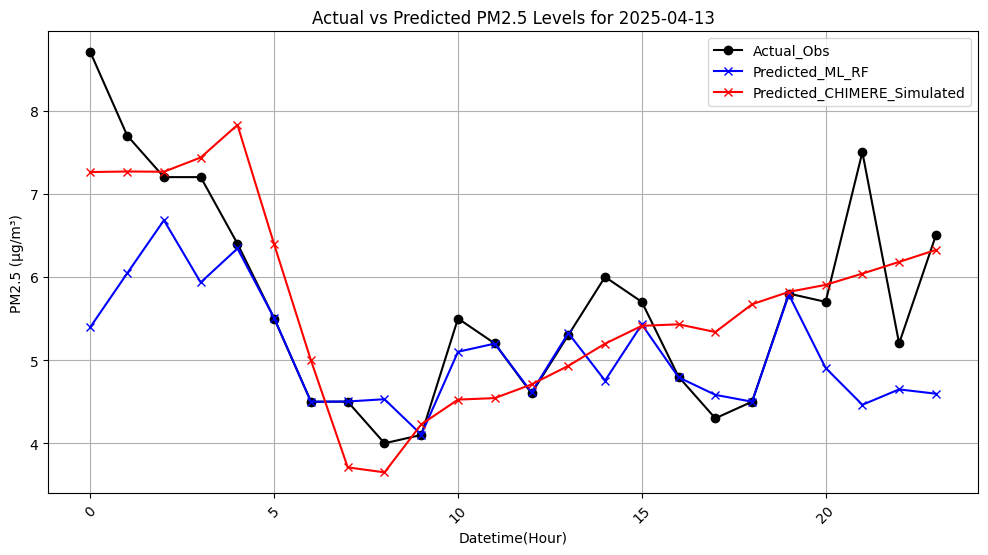

         date  rmse_actual_vs_pred_RF  rmse_actual_vs_PM25
0  2025-04-13                1.144762              0.77528


In [ ]:
import ast
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the predictions
pred_df = pd.read_csv("/content/drive/MyDrive/DS_project/ML_results/predictions_2025-04-13.csv", parse_dates=["Datetime"])

pred_df['Actual'] = pred_df['Actual'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
pred_df['Predicted'] = pred_df['Predicted'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
#pred_df['Datetime'] = pred_df['Datetime'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
pred_df['CI_Lower_95']= pred_df['CI_Lower_95'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
pred_df['CI_Upper_95']= pred_df['CI_Upper_95'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)
print(pred_df.dtypes)
pred_df.head(5)
#convert to datetime
pred_df['Datetime'] = pd.to_datetime(pred_df['Datetime'])
# Ensure 'Datetime' is in datetime format and extract the date
pred_df['date'] = pred_df['Datetime'].dt.date

test_date = pred_df['date'].iloc[0]  # gets the first (and only) date

pred_df['Hour'] = pred_df['Datetime'].dt.hour
pred_df['Month'] = pred_df['Datetime'].dt.month
pred_df.head(5)
simulated_df = pd.read_csv("/content/drive/MyDrive/DS_project/test_sim.csv") #time_counter, PM25
simulated_df['Hour'] = simulated_df['Time'].str.split(':').str[0].astype(int)
simulated_df['Year'] = 2025
# Combine columns into a datetime string and parse it
simulated_df['Datetime'] = pd.to_datetime(
    simulated_df['Year'].astype(str) + '-' +
    simulated_df['Month'].astype(str).str.zfill(2) + '-' +
    simulated_df['Day'].astype(str).str.zfill(2) + ' ' +
    simulated_df['Time'].astype(str),
    format='%Y-%m-%d %H:%M'
)
simulated_df = simulated_df[['Datetime', 'Fine particles <2.5 µm [µg/m3]']]
simulated_df.rename(columns={'Fine particles <2.5 µm [µg/m3]': 'PM25'}, inplace=True)
simulated_df.head(5)
#combine pred_df and simulated_df by Hour
df_eval = pred_df.merge(simulated_df, on='Datetime', how='left')


# Plot actual vs predicted line chart
plt.figure(figsize=(12, 6))
plt.plot(df_eval['Hour'], df_eval['Actual'], label='Actual_Obs', marker='o',c='black')
plt.plot(df_eval['Hour'], df_eval['Predicted'], label='Predicted_ML_RF', marker='x',c='blue')
plt.plot(df_eval['Hour'], df_eval['PM25'], label='Predicted_CHIMERE_Simulated', marker='x',c='r')

# Plot Confidence Intervals
#plt.fill_between(df_eval['Hour'], df_eval['CI_Lower_95'], df_eval['CI_Upper_95'], color='grey', alpha=0.3, label='95% CI')


plt.title(f'Actual vs Predicted PM2.5 Levels for {test_date}')
plt.xlabel('Datetime(Hour)')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.savefig(f'/content/drive/MyDrive/DS_project/ML_results/actual_vs_predicted_chart_{test_date}.png')

plt.show()
#save chart#
# Compute RMSE values
rmse_actual_vs_pred = np.sqrt(mean_squared_error(df_eval['Actual'], df_eval['Predicted']))
rmse_actual_vs_sim = np.sqrt(mean_squared_error(df_eval['Actual'], df_eval['PM25']))

# Create a DataFrame with RMSE values and corresponding date
rmse_df = pd.DataFrame([{
    'date': df_eval['date'].iloc[0],
    'rmse_actual_vs_pred_RF': rmse_actual_vs_pred,
    'rmse_actual_vs_PM25': rmse_actual_vs_sim
}])

# Save to CSV
rmse_df.to_csv(f'/content/drive/MyDrive/DS_project/ML_results/rmse_{test_date}.csv', index=False)

# Optional: print to confirm
print(rmse_df)

# save result df as csv add datetime in file name
df_eval.to_csv(f'df_eval_{test_date}.csv', index=False)
df_eval.to_csv(f'/content/drive/MyDrive/DS_project/ML_results/df_eval_{test_date}.csv', index=False)






In [ ]:
import plotly.graph_objects as go

# Create traces for each line plot
trace_actual = go.Scatter(
    x=df_eval['Hour'],
    y=df_eval['Actual'],
    mode='markers+lines',
    name='Actual_Obs',
    marker=dict(symbol='circle', color='black')
)

trace_predicted_rf = go.Scatter(
    x=df_eval['Hour'],
    y=df_eval['Predicted'],
    mode='markers+lines',
    name='Predicted_ML_RF',
    marker=dict(symbol='x', color='blue')
)

trace_predicted_simulated = go.Scatter(
    x=df_eval['Hour'],
    y=df_eval['PM25'],
    mode='markers+lines',
    name='Predicted_CHIMERE_Simulated',
    marker=dict(symbol='x', color='red')
)

# CI Upper trace (invisible, just for filling)
trace_ci_upper = go.Scatter(
    x=df_eval['Hour'],
    y=df_eval['CI_Upper_95'],
    mode='lines',
    line=dict(width=0),
    showlegend=False,
    name='CI Upper',
    hoverinfo='skip'
)

# CI Lower trace (with fill to upper)
trace_ci_lower = go.Scatter(
    x=df_eval['Hour'],
    y=df_eval['CI_Lower_95'],
    mode='lines',
    line=dict(width=0),
    fill='tonexty',
    fillcolor='rgba(128, 128, 128, 0.3)',  # light grey transparency
    name='95% CI',
    hoverinfo='skip'
)

# Combine the traces
data = [trace_actual, trace_predicted_rf, trace_ci_upper, trace_ci_lower, trace_predicted_simulated]

# Create the layout
layout = go.Layout(
    title=f'Actual vs Predicted PM2.5 Levels for {test_date}',
    xaxis=dict(
        title='Hour of Day',
        gridcolor='lightgrey',
        tickangle=45
    ),
    yaxis=dict(
        title='PM2.5 (µg/m³)',
        gridcolor='lightgrey'
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Save the figure to a file
fig.write_html(f'/content/drive/MyDrive/DS_project/ML_results/actual_vs_predicted_chart_{test_date}.html')

# Show the plot
fig.show()


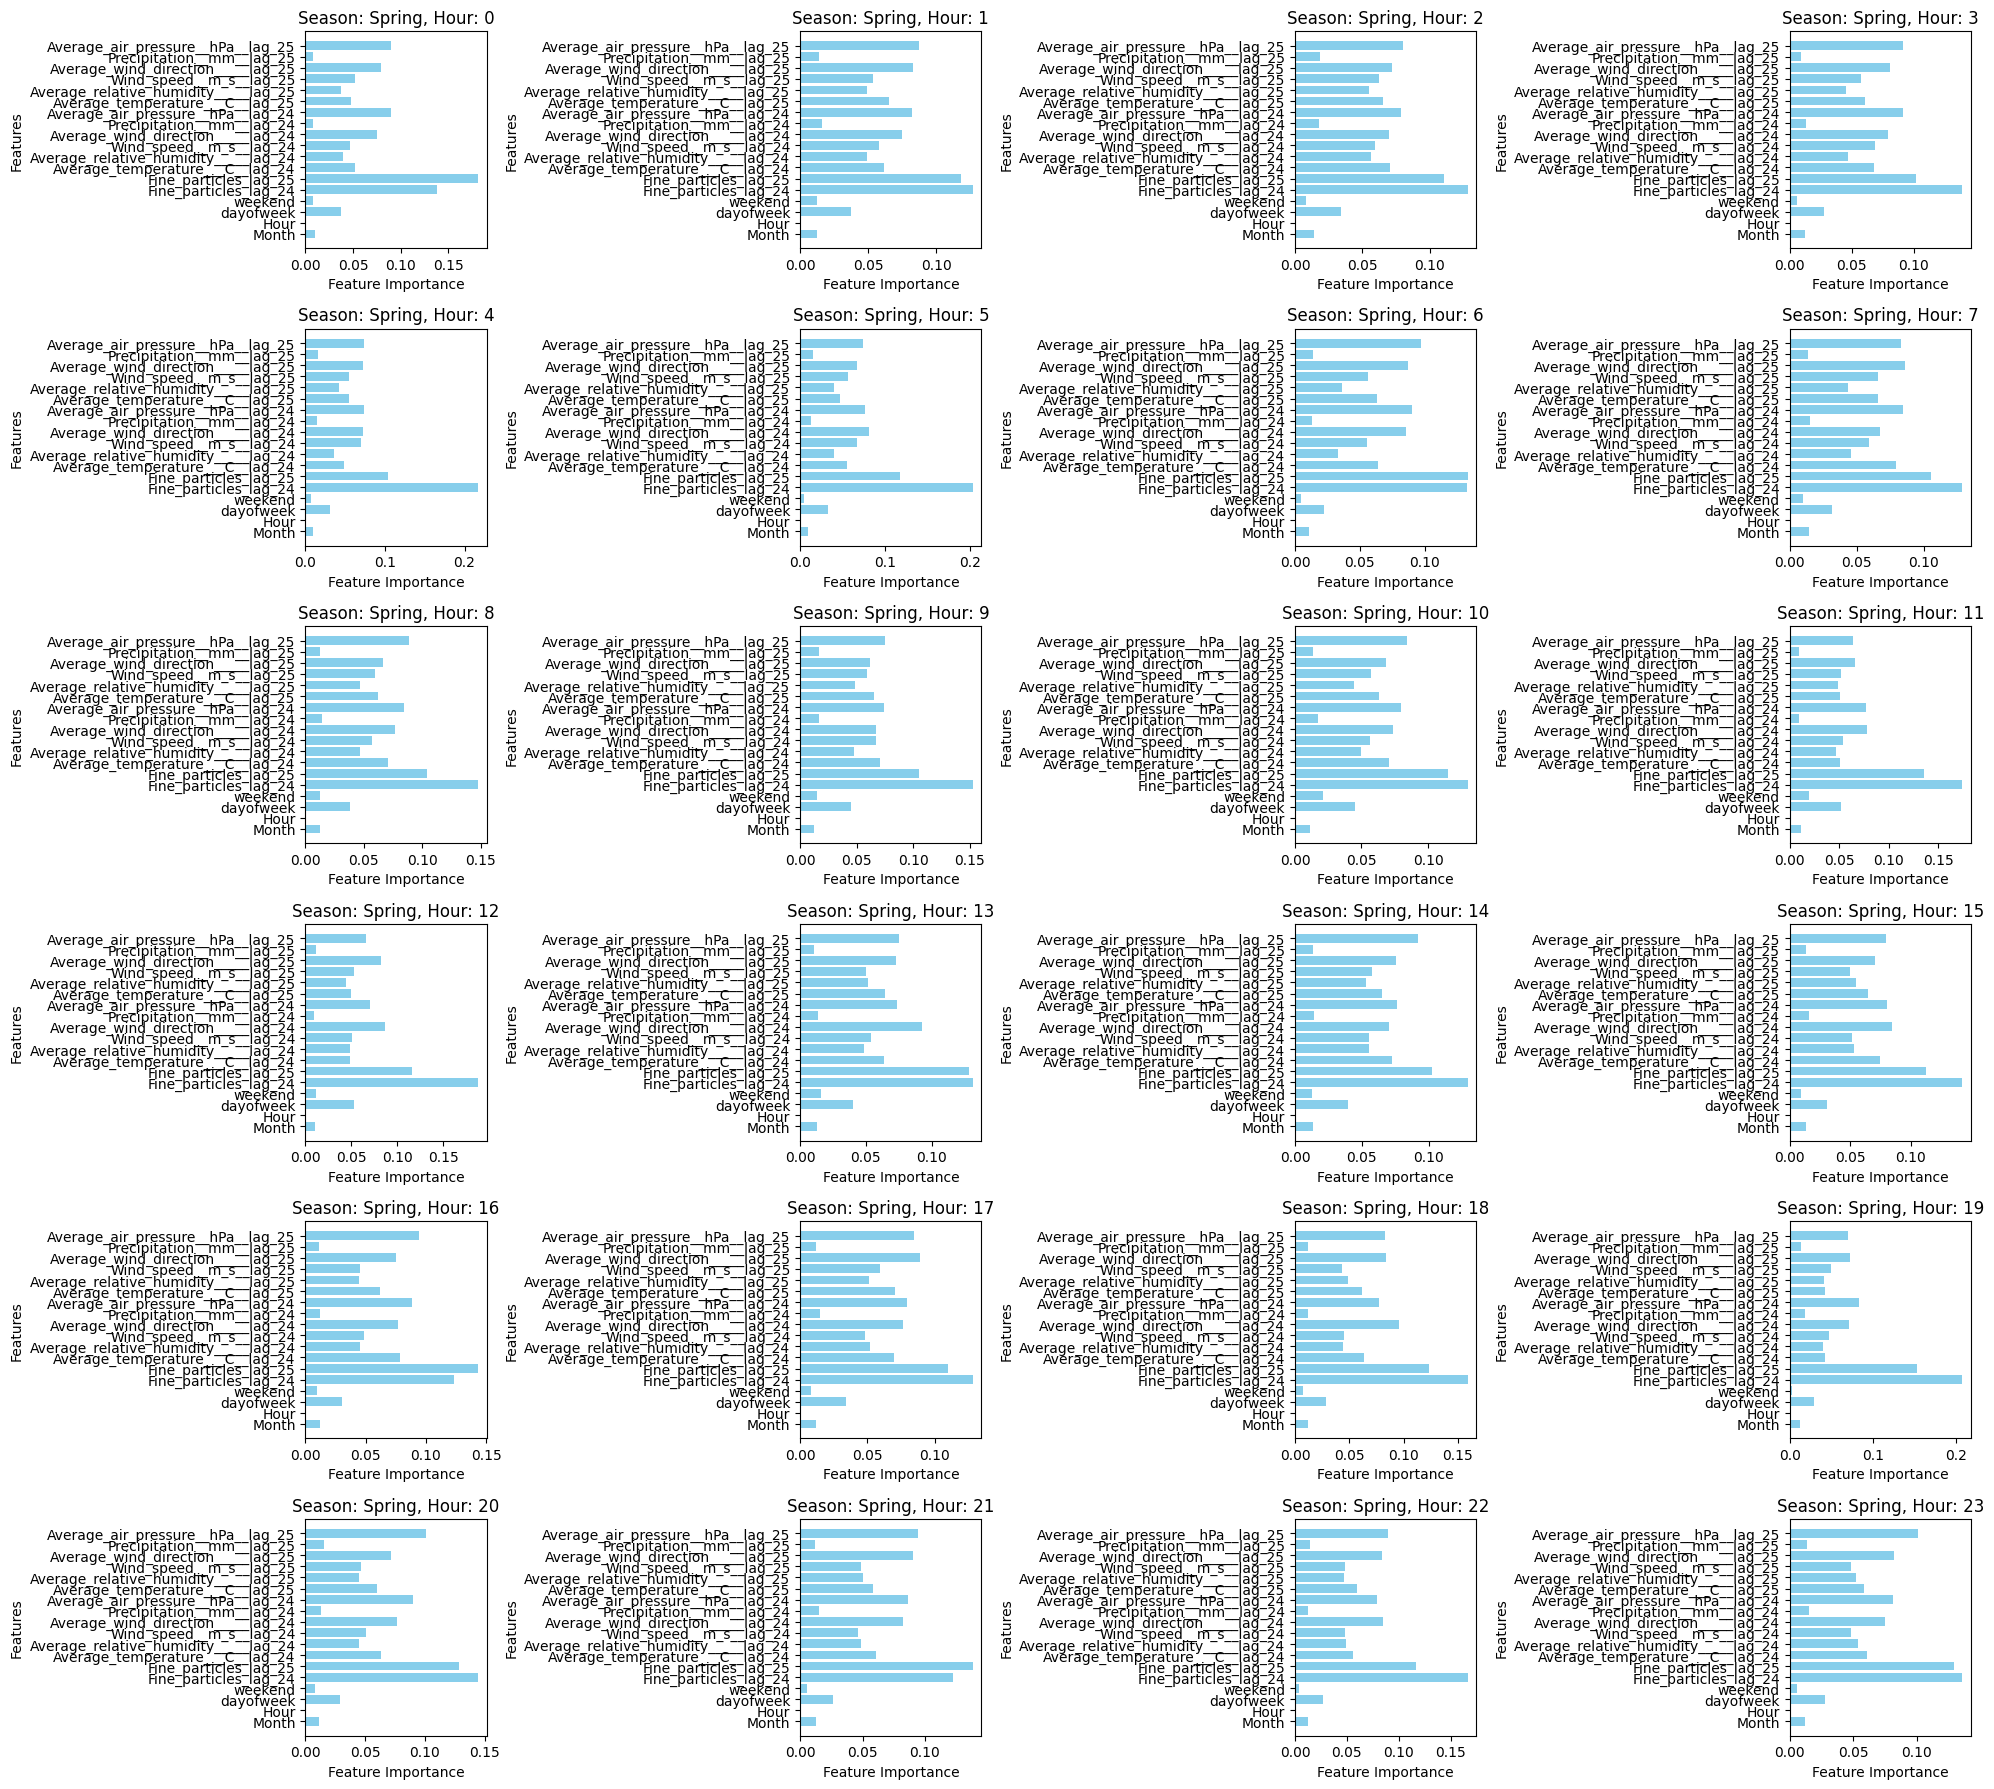

Mean Squared Error (Original Scale) for season Spring, hour 0: 10.897283039279689
Mean Squared Error (Original Scale) for season Spring, hour 1: 2.7440983004490858
Mean Squared Error (Original Scale) for season Spring, hour 2: 0.2687782341507074
Mean Squared Error (Original Scale) for season Spring, hour 3: 1.6034329935698541
Mean Squared Error (Original Scale) for season Spring, hour 4: 0.003352329218107567
Mean Squared Error (Original Scale) for season Spring, hour 5: 1.6583632400010546e-05
Mean Squared Error (Original Scale) for season Spring, hour 6: 8.15492664685229e-07
Mean Squared Error (Original Scale) for season Spring, hour 7: 5.4068898400610815e-06
Mean Squared Error (Original Scale) for season Spring, hour 8: 0.28057616621304243
Mean Squared Error (Original Scale) for season Spring, hour 9: 1.9626210086054447e-05
Mean Squared Error (Original Scale) for season Spring, hour 10: 0.16006492524942526
Mean Squared Error (Original Scale) for season Spring, hour 11: 2.5288197873237

In [ ]:
# Plot feature importances for each season and hour in the same figure
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 18))  # Adjust the number of rows and columns based on the number of seasons
axes = axes.flatten()  # Flatten the axes for easier indexing

for idx, result in enumerate(feature_importances):
    season = result['Season']
    hour = result['Hour']
    importances = result['Importances']
    features = result['Features']

    # Plot feature importances for each season and hour
    ax = axes[idx]
    ax.barh(features, importances, color='skyblue')
    ax.set_title(f"Season: {season}, Hour: {hour}")
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Features')

# Adjust layout
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/DS_project/ML_results/feature_importances_plots_{test_date}.png')
plt.show()

# Optionally, calculate and print MSE for each hour/season
for result in predictions:
    season = result['Season']
    hour = result['Hour']

    mse_original = mean_squared_error(result['Actual'], result['Predicted'])
    print(f"Mean Squared Error (Original Scale) for season {season}, hour {hour}: {mse_original}")

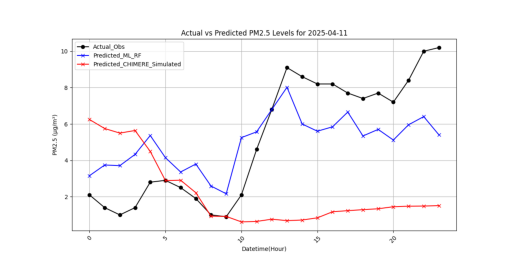

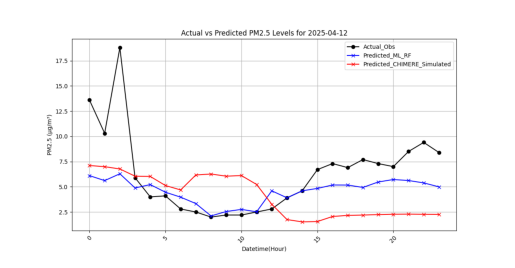

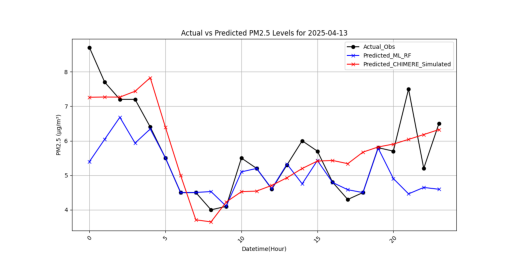

In [ ]:
import glob
import os
import matplotlib.pyplot as plt

# Get a list of all PNG files in the directory
png_files = glob.glob('/content/drive/MyDrive/DS_project/ML_results/*.png')

# Filter to only include files starting with "actual_vs_predicted_chart_2025-04-12"
png_files = [f for f in png_files
             if os.path.basename(f).startswith("actual_vs_predicted_chart") and f.endswith(".png")]

# Sort the files to ensure they are in the correct order
png_files.sort()

# Plot each PNG
for png_file in png_files:
    img = plt.imread(png_file)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()


In [ ]:
#Print RMSE
import pandas as pd
import glob
import os

# Folder containing your RMSE files
folder_path = "/content/drive/MyDrive/DS_project/ML_results"

# Adjust pattern as needed, e.g. all CSVs containing RMSE in their name
rmse_files = glob.glob(os.path.join(folder_path, "*rmse*.csv"))

# Read and concatenate all RMSE files
df_list = [pd.read_csv(f) for f in rmse_files]
rmse_combined = pd.concat(df_list, ignore_index=True)

# Display the result
print(rmse_combined)


         date  rmse_actual_vs_pred_RF  rmse_actual_vs_PM25
0  2025-04-11                2.289388             5.465238
1  2025-04-13                1.144762             0.775280
2  2025-04-12                3.550996             4.881365


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import glob
import os

# Define folder path and file pattern
folder_path = "/content/drive/MyDrive/DS_project/ML_results"
file_pattern = "df_eval_2025-04-1[1-3]*.csv"  # Matches 11, 12, 13

# Get list of matching files
eval_files = glob.glob(os.path.join(folder_path, file_pattern))

# Read and concatenate all files
df_list = [pd.read_csv(f) for f in eval_files]
df_combined = pd.concat(df_list, ignore_index=True)

# Ensure columns are stripped of whitespace
df_combined.columns = df_combined.columns.str.strip()

# Compute RMSEs
rmse_actual_predicted = np.sqrt(mean_squared_error(df_combined['Actual'], df_combined['Predicted']))
rmse_actual_pm25 = np.sqrt(mean_squared_error(df_combined['Actual'], df_combined['PM25']))

# Print the RMSE results
print("RMSE (Actual vs RF Predicted PM2.5):", rmse_actual_predicted)
print("RMSE (Actual vs CHIMERE PM2.5):", rmse_actual_pm25)


RMSE (Actual vs RF Predicted PM2.5): 2.5272742748743546
RMSE (Actual vs CHIMERE PM2.5): 4.254315887201181


In [ ]:
## END